In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import importlib
from warnings import warn
import time
import shutil
import os
import imageio

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['image.cmap'] = 'binary'
plt.rcParams['figure.figsize'] = (14, 11)
plt.rcParams['font.size'] = 20

try:
    from mpi4py import MPI
except:
    pass

In [ ]:
%%writefile rule110.py

import numpy as np
import importlib
from warnings import warn
import time
import shutil
import os
import imageio

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'binary'
plt.rcParams['figure.figsize'] = (14, 11)
plt.rcParams['font.size'] = 20

try:
    from mpi4py import MPI
except:
    pass

def rules1D(i, curr_system, length_loc):
        abc = curr_system
        a = abc[(i-1) % length_loc]
        b = abc[i]
        c = abc[(i+1) % length_loc]

        cell_state = (not c and b) or (c and not (a and b))
        return cell_state

def livingCellsvsTime(rule110_seq, rule110_par):
    assert isinstance((rule110_seq, rule110_par), Rule110)
    assert rule110_seq.init_cond == rule110_par.init_cond
    assert rule110_seq.init_cond_repeat == rule110_par.init_cond_repeat

    plt.plot(rule110_seq.wall_time, rule110_seq.living_cells, label='Sequential')
    plt.plot(rule110_seq.wall_time, rule110_seq.living_cells, label='Parallel')
    plt.xlabel('Time, ms')
    plt.ylabel('# of living cells')
    plt.title(f'Start with {rule110_seq.init_cond} x {rule110_seq.init_cond_repeat}')
    return


class Rule110(object):
    def __init__(self,
                 init_cond: list,
                 init_cond_repeat: int,
                 dimen=1):
        assert isinstance(init_cond, (list, tuple, np.ndarray))
        assert set(init_cond) == {0, 1}
        assert isinstance(init_cond_repeat, int)
        assert init_cond_repeat > 0
        assert dimen in (1, 2, 3)

        self.init_cond = init_cond
        self.init_cond_repeat = init_cond_repeat
        self.dimen = dimen
        
        self.evolution = np.array([self.init_cond * self.init_cond_repeat])
        self.living_cells = np.array(np.sum(self.evolution))
        self.wall_time = np.array([0])
        self.length = self.evolution.shape[1]
        self.chooseRules()
        return

    def __call__(self, evolution_steps, run_name, use_parallel=True, write_gifs=False, write_npz=True, write_evol=False):

        is_mpi4py = importlib.util.find_spec("mpi4py")
        if not is_mpi4py and use_parallel:
            warn('Choosen a parallel implementation, but "mpi4py" is not installed.\nFalling back to sequential implementation')

        if is_mpi4py and use_parallel:
            size_comm_mpi = self.parLoop(evolution_steps)
            if write_npz & write_evol:
                np.savez('rule110Parallel_' + run_name + '_' + str(size_comm_mpi) + 'process.npz',
                         evolution=self.evolution,
                         wall_time=self.wall_time,
                         living_celss=self.living_cells)
            elif write_npz:
                np.savez('rule110Parallel_' + run_name + '_' + str(size_comm_mpi) + 'process.npz',
                         wall_time=self.wall_time,
                         living_celss=self.living_cells)
        else:
            print('> Calculate system states.')
            self.seqLoop(evolution_steps)
            if write_gifs:
                print('> Create "one state" animation')
                self.oneStateAnimation()
                print('> Create "history" animation')
                self.historyAnimation()
        return

    def seqLoop(self, evolution_steps):
        for _ in tqdm(range(evolution_steps)):
            wall_t = time.time()
            curr_system = self.evolution[-1, :]
            new_system = np.empty_like(curr_system)

            for i in range(self.length):
                new_system[i] = self.checkPoint(i, curr_system, self.length)
            self.evolution = np.vstack([self.evolution, new_system])

            wall_t = time.time() - wall_t
            self.wall_time = np.append(self.wall_time, wall_t)
            self.living_cells = np.append(self.living_cells, np.sum(new_system))        

    def parLoop(self, evolution_steps):
        comm = MPI.COMM_WORLD
        size = comm.Get_size()
        rank = comm.Get_rank()

        evolution = np.empty([evolution_steps+1, self.length])
        evolution[0, :] = self.evolution[-1, :]

        curr_system = evolution[0, :]
        curr_system_per_rank = np.array_split(curr_system, size)
        curr_system_local = curr_system_per_rank[rank]

        length_per_rank = np.array_split(np.arange(self.length), size)
        length_local = length_per_rank[rank].shape[0]

        for step in tqdm(range(evolution_steps)):
            wall_t = time.time()

            new_system_local = np.empty(curr_system_local.shape[0]+2)
            first_old = np.array([curr_system_local[0]])
            last_old = np.array([curr_system_local[-1]])

            first_new = np.empty_like(first_old)
            last_new = np.empty_like(first_old)

            comm.Send([last_old, MPI.FLOAT], dest=(rank+1)%size, tag=0)
            comm.Recv([first_new, MPI.FLOAT], source=(rank-1)%size, tag=0)

            comm.Send([first_old, MPI.FLOAT], dest=(rank-1)%size, tag=1)
            comm.Recv([last_new, MPI.FLOAT], source=(rank+1)%size, tag=1)

            curr_system_local = np.append(first_new, curr_system_local)
            curr_system_local = np.append(curr_system_local, last_new)

            for i in range(length_local+2):
                new_system_local[i] = self.checkPoint(i, curr_system_local, length_local+2)
            new_system_local = new_system_local[1:-1]

            whole_system = comm.gather(new_system_local, root=0)
            if rank == 0:
                whole_system = np.concatenate(whole_system, axis=0)
                evolution[step+1, :] = whole_system

            curr_system_local = new_system_local
            wall_t = time.time() - wall_t
            self.wall_time = np.append(self.wall_time, wall_t)
            self.living_cells = np.append(self.living_cells, np.sum(whole_system))

        self.evolution = evolution
        return size

    def chooseRules(self, ):
        if self.dimen == 1:
            self.checkPoint = rules1D
        else:
            raise ValueError('Not implemented')
        return 

    def oneStateAnimation(self, name, dir='r110_one_pics/', frame_per_pic=4):
        filenames_one = []
        if os.path.isdir(dir):
            warn('The directory exists. Cleaning Directory')
            shutil.rmtree(dir)
        os.mkdir(dir)

        for n in tqdm(range(self.evolution.shape[0])):
            plt.imshow(self.evolution[n, :].reshape(1, -1))
            plt.grid(color='red', linewidth=3)

            plt.xticks(np.arange(self.length+1)-0.5, []);
            plt.yticks([])
            plt.title(f'Iteartion {n}\nStart with {self.init_cond} x {self.init_cond_repeat}')

            for j in range(frame_per_pic):
                filename = f'{n}_' + str(j) + '.png'
                filenames_one.append(filename)
                
                plt.savefig(os.path.join(dir, filename))
            plt.close()

        self.makeGif(filenames_one, dir=dir, name=name)
        return

    def historyAnimation(self, name, dir='r110_hist_pics/', hist_num=5, frame_per_pic=6):
        filenames_hist = []
        if os.path.isdir(dir):
            warn('The directory exists. Cleaning Directory')
            shutil.rmtree(dir)
        os.mkdir(dir)

        fig, axes = plt.subplots(hist_num, 1, figsize=(11, 20))

        for n in tqdm(range(self.evolution.shape[0]-hist_num)):
            for i in range(axes.shape[0]):
                axes[i].imshow(self.evolution[n+i, :].reshape(1, -1))
                axes[i].grid(color='red', linewidth=3)
                axes[i].set_xticks(np.arange(self.length+1)-0.5);
                axes[i].tick_params(axis='x', labelsize=0)
                axes[i].set_yticks([])
                axes[i].set_title(f'#{n+i}. Start with {self.init_cond} x {self.init_cond_repeat}')
            plt.subplots_adjust(hspace=0.1)
            
            for j in range(frame_per_pic):
                filename = f'{n}_' + str(j) + '.png'
                filenames_hist.append(filename)
                
                fig.savefig(os.path.join(dir, filename))
            plt.close()
        self.makeGif(filenames_hist, dir=dir, name=name)
        return

    def makeGif(self, filenames, dir, name):
        mode = 'oneState' if dir == 'r110_one_pics/' else 'history'
        name = 'Trifonov_r110' + '_' + name
        print(f'  > Writing "{name}_{mode}" gif')
        with imageio.get_writer(f'{name}_{mode}.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(dir + filename)
                writer.append_data(image)
        print('  > Gif is written. Cleaning parent directory.')
        for filename in set(filenames):
            os.remove(dir + filename)
        return

Overwriting rule110.py


## Check Sequential Implementation

In [ ]:
from rule110 import *

In [ ]:
r110 = Rule110([0, 0, 0, 1, 1, 1, 0, 1, 1, 1], 4)
check_seq_name = 'checkSeq'
r110(evolution_steps=20, run_name=check_seq_name, use_parallel=False, write_gifs=False, write_npz=False)
r110.oneStateAnimation(name=check_seq_name, frame_per_pic=10)
r110.historyAnimation(name=check_seq_name, hist_num=5, frame_per_pic=10)

> Calculate system states.


  0%|          | 0/20 [00:00<?, ?it/s]

/content/rule110.py:168: UserWarning: The directory exists. Cleaning Directory
  warn('The directory exists. Cleaning Directory')


  0%|          | 0/21 [00:00<?, ?it/s]

  > Writing "Trifonov_r110_checkSeq_oneState" gif
  > Gif is written. Cleaning parent directory.


/content/rule110.py:193: UserWarning: The directory exists. Cleaning Directory
  warn('The directory exists. Cleaning Directory')


  0%|          | 0/16 [00:00<?, ?it/s]

  > Writing "Trifonov_r110_checkSeq_history" gif
  > Gif is written. Cleaning parent directory.


## Check Parallel Implementation

In [ ]:
%%writefile run_rule110_par.py
from rule110 import *
check_par_name = 'checkPar'
r110 = Rule110([0, 0, 0, 1, 1, 1, 0, 1, 1, 1], 4)
r110(evolution_steps=20, run_name=check_par_name, use_parallel=True, write_gifs=False, write_npz=True, write_evol=True)

Overwriting run_rule110_par.py


In [ ]:
!mpirun --allow-run-as-root -n 3 python run_rule110_par.py

  0%|          | 0/20 [00:00<?, ?it/s]


In [ ]:
r110_par = Rule110([0, 0, 0, 1, 1, 1, 0, 1, 1, 1], 4)
r110_par.evolution = np.load('rule110Parallel_checkPar_3process.npz')['evolution']
r110_par.oneStateAnimation(name='checkPar', frame_per_pic=3)
# r110_par.historyAnimation(name='checkPar', hist_num=5, frame_per_pic=10)

  0%|          | 0/21 [00:00<?, ?it/s]

  > Writing "Trifonov_r110_checkPar_oneState" gif
  > Gif is written. Cleaning parent directory.


## Long Gif

In [ ]:
r110_longGif = Rule110([0, 0, 0, 1, 1, 1, 0, 1, 1, 1], 1)
run_n = 'longGif'
r110_longGif(evolution_steps=1000, run_name=run_n, use_parallel=False, write_gifs=False, write_npz=False)
r110_longGif.oneStateAnimation(name=run_n, frame_per_pic=4)
# r110_longGif.historyAnimation(name=run_n, hist_num=5, frame_per_pic=4)

## Initial condition of my choice

In [ ]:
r110_myInitCond = Rule110([1, 0, 0, 1, 1, 1, 0, 1, 1, 1], 4)
run_n = 'myInitCond'
r110_myInitCond(evolution_steps=500, run_name=run_n, use_parallel=False, write_gifs=False, write_npz=False)
r110_myInitCond.oneStateAnimation(name=run_n, frame_per_pic=4)

> Calculate system states.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

  > Writing "Trifonov_r110_myInitCond_oneState" gif
  > Gif is written. Cleaning parent directory.


## Number of Living Cells vs Time

In [ ]:
ln = 100
steps = 40

In [ ]:
r110_bigInputSeq = Rule110([0, 0, 0, 1, 1, 1, 0, 1, 1, 1], ln)
run_n = 'bigInputSeq'
r110_bigInputSeq(evolution_steps=steps, run_name=run_n, use_parallel=False, write_gifs=False, write_npz=False)

> Calculate system states.


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
r110_bigInputSeq_my = Rule110([1, 0, 0, 1, 1, 1, 0, 1, 1, 1], ln)
run_n_my = 'bigInputSeq_my'
r110_bigInputSeq_my(evolution_steps=steps, run_name=run_n_my, use_parallel=False, write_gifs=False, write_npz=False)

> Calculate system states.


  0%|          | 0/40 [00:02<?, ?it/s]

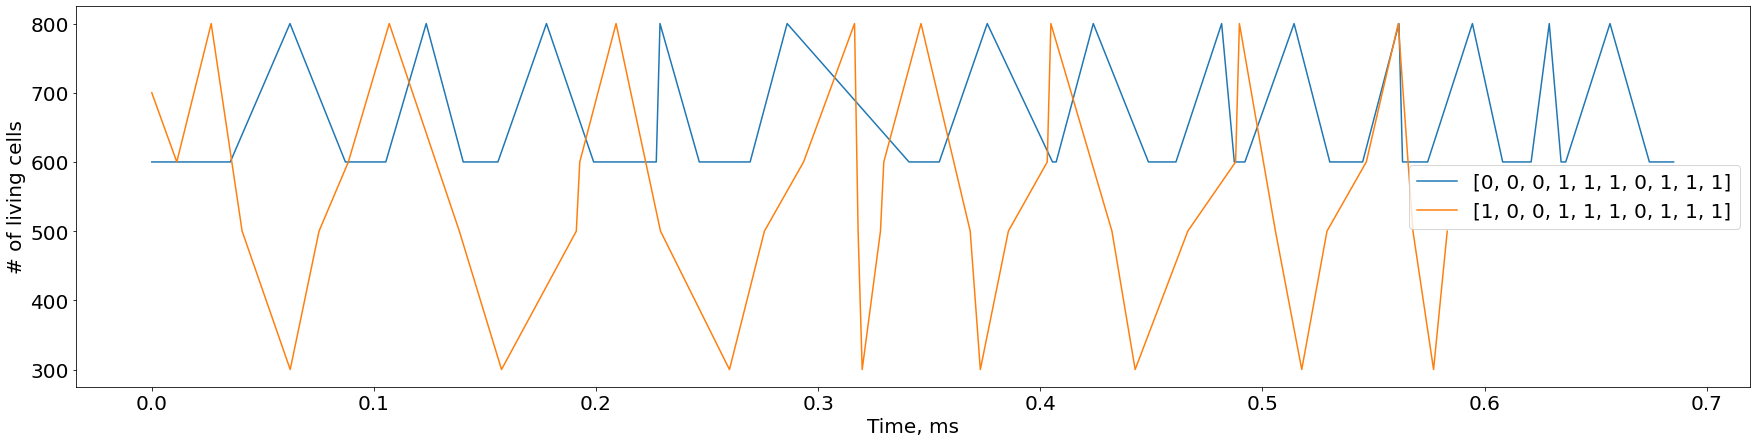

In [ ]:
plt.rcParams['figure.figsize'] = (30, 7)
plt.plot(np.cumsum(r110_bigInputSeq.wall_time), r110_bigInputSeq.living_cells, label='[0, 0, 0, 1, 1, 1, 0, 1, 1, 1]')
plt.plot(np.cumsum(r110_bigInputSeq_my.wall_time), r110_bigInputSeq_my.living_cells, label='[1, 0, 0, 1, 1, 1, 0, 1, 1, 1]')

plt.xlabel('Time, ms')
plt.ylabel('# of living cells')
plt.legend();